<a href="https://colab.research.google.com/github/harishk30/RingGalaxiesCNNAnalysis/blob/main/TransferLearn/NoTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
pip install split-folders tqdm

In [ ]:
!unzip /content/drive/MyDrive/RING_GAL_DATA_SORTED_5.zip -d /content/final_sort

In [ ]:
import splitfolders
splitfolders.ratio('/content/final_sort/RING_GAL_DATA_SORTED_4', output="output", seed=1337, ratio=(0.8, 0.1, 0.1)) 

Copying files: 9328 files [00:02, 3304.57 files/s]


In [ ]:
basetrain_dir = '/content/output/train/'
training_dir = pathlib.Path(basetrain_dir)
baseval_dir = '/content/output/val/'
validation_dir = pathlib.Path(baseval_dir)
basetest_dir = '/content/output/test/'
test_dir = pathlib.Path(basetest_dir)

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
data_aug = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range = 0.1, height_shift_range = 0.1, 	shear_range=1.2, zoom_range=0.25, rotation_range=360)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_ds = data_aug.flow_from_directory(
	training_dir,  
	target_size=(img_height, img_width),  
	batch_size = batch_size,
	class_mode='binary')

Found 7461 images belonging to 2 classes.


In [ ]:
validation_ds = test_gen.flow_from_directory(
	validation_dir,
	target_size=(img_height, img_width),
	batch_size = batch_size,
	class_mode='binary')

Found 932 images belonging to 2 classes.


In [ ]:
confirmation_generator = test_gen.flow_from_directory(
  test_dir,
	target_size = (img_height, img_width),
	batch_size = batch_size,
	class_mode=None,
	shuffle=False)

Found 935 images belonging to 2 classes.


Model

In [ ]:
sim_model = Sequential()

ResNet_50 = ResNet50(include_top = False, 
                     weights = None,
                     input_shape = (256, 256, 3),
                     pooling = 'max',
                     classes = 2)

ResNet_50.trainable = True
ResNet_50 = add_regularization(ResNet_50)

sim_model.add(ResNet_50)
sim_model.add(Flatten())
sim_model.add(Dense(512, activation = 'relu'))
sim_model.add(Dense(1, activation = 'sigmoid'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
import os
import tempfile

def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [ ]:
sim_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 1)                513       
 pper)                                                           
                                                                 
Total params: 24,637,313
Trainable params: 24,584,193
Non-trainable params: 53,120
_____________________________________

In [ ]:
sim_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs = 1000
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = sim_model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = epochs,
    callbacks = [callback]
)

Epoch 1/1000
234/234 [==============================] - 138s 521ms/step - loss: 2.7401 - accuracy: 0.6967 - val_loss: 2.4823 - val_accuracy: 0.6427
Epoch 2/1000
234/234 [==============================] - 119s 507ms/step - loss: 2.4509 - accuracy: 0.7467 - val_loss: 2.8896 - val_accuracy: 0.6406
Epoch 3/1000
234/234 [==============================] - 117s 501ms/step - loss: 2.3298 - accuracy: 0.7811 - val_loss: 2.1965 - val_accuracy: 0.8423
Epoch 4/1000
234/234 [==============================] - 117s 500ms/step - loss: 2.3071 - accuracy: 0.7983 - val_loss: 2.1242 - val_accuracy: 0.8873
Epoch 5/1000
234/234 [==============================] - 117s 500ms/step - loss: 2.2206 - accuracy: 0.8309 - val_loss: 2.1334 - val_accuracy: 0.8906
Epoch 6/1000
234/234 [==============================] - 119s 509ms/step - loss: 2.1561 - accuracy: 0.8641 - val_loss: 2.0754 - val_accuracy: 0.8948
Epoch 7/1000
234/234 [==============================] - 119s 508ms/step - loss: 2.1315 - accuracy: 0.8719 - val_

Evaluation

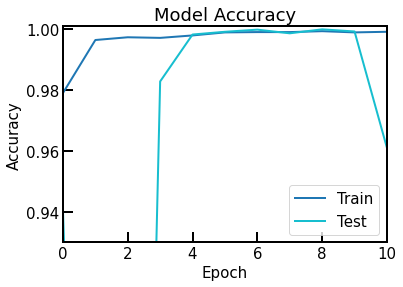

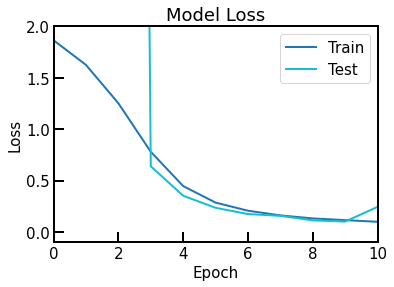

In [ ]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm
import matplotlib.font_manager as fm

#accuracy
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 2
colors = cm.get_cmap('tab10', 2)
fig = plt.figure(figsize=(4.5, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.plot([0.9790, 0.9964, 0.9973, 0.9971, 0.9979, 0.9989, 0.9990, 0.9990, 0.9993, 0.9989, 0.9991], color = colors(0), linewidth = 2)
ax.plot([0.9405, 0.6335, 0.5302, 0.9828, 0.9982, 0.9991, 0.9998, 0.9986, 0.9999, 0.9992, 0.9610], color = colors(1), linewidth = 2)
ax.set_ylim(0.93, 1.0009)
ax.set_xlim(0, 10)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

#loss
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 2
colors = cm.get_cmap('tab10', 2)
fig = plt.figure(figsize=(4.5, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.plot([1.8642, 1.6245, 1.2519, 0.7798, 0.4468, 0.2859, 0.2071, 0.1615, 0.1322, 0.1158, 0.0993], color = colors(0), linewidth = 2)
ax.plot([2.1360, 5.6161, 35.5136, 0.6390, 0.3525, 0.2354, 0.1744, 0.1572, 0.1134, 0.1017, 0.2445], color = colors(1), linewidth = 2)
ax.set_ylim(-0.1, 2)
ax.set_xlim(0, 10)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
def get_predictions(generator,model):
	test_steps_per_epoch = np.math.ceil(generator.samples / generator.batch_size)
	predictions = model.predict_generator(generator, steps=test_steps_per_epoch)
	predictions = [i[0] for i in predictions]
	predictions = np.array(predictions)
	return predictions


def prediction_report(predictions,generator,cutoff,chatter=False):
	predicted_classes = np.copy(predictions)
	predicted_classes[predicted_classes>cutoff] = 1.0
	predicted_classes[predicted_classes<cutoff] = 0.0 
	true_classes = generator.classes
	N_ring = len(np.where(true_classes>0.5)[0])
	N_normal = len(np.where(true_classes<0.5)[0])
	tn, fp, fn, tp = confusion_matrix(true_classes,predicted_classes).ravel()
	matrix = confusion_matrix(true_classes,predicted_classes)
	if chatter:
		print('True Normal predictions: {} | ({} percent)'.format(tn,(tn * 100)/N_normal))
		print('True Ring predictions: {} | ({} percent)'.format(tp,(tp * 100)/N_ring))
		print('False Normal predictions (actually Ring): {} | ({} percent)'.format(fn,(fn * 100)/N_ring))
		print('False Ring predictions (actually Normal): {} | ({} percent)'.format(fp,(fp * 100)/N_normal))
	return(tn, fp, fn, tp)

def MCC(theta):
	tn, fp, fn, tp = theta
	numerator = (tp*tn) - (fp*fn)
	denomenator = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
	MCC = numerator / denomenator
	return MCC

def AUC(predictions,generator):
	thresholds = np.linspace(0.0,1,20)
	tprs = []
	fprs = []
	for i in thresholds:
		tn, fp, fn, tp = prediction_report(predictions,generator,cutoff=i,chatter=False)
		TPR = tp / (fn+tp)
		FPR = fp / (fp+tn)
		tprs.append(TPR)
		fprs.append(FPR)
	tprs = np.array(tprs)[::-1]
	fprs = np.array(fprs)[::-1]
	plt.plot(fprs,tprs)
	plt.plot([0,1],[0,1],'k')
	area = np.trapz(tprs,x=fprs)
	print("Area under the curve: {}".format(area))
	return area


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


True Normal predictions: 575 | (92.44372990353698 percent)
True Ring predictions: 220 | (70.28753993610223 percent)
False Normal predictions (actually Ring): 93 | (29.712460063897762 percent)
False Ring predictions (actually Normal): 47 | (7.556270096463023 percent)
MCC:  0.6554017218983229
Area under the curve: 0.8848324995120347


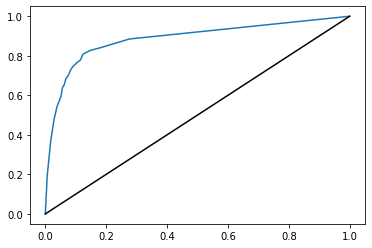

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = get_predictions(confirmation_generator,sim_model)
theta = prediction_report(predictions,confirmation_generator,cutoff=0.5,chatter=True)
mcc = MCC(theta)
print('MCC: ',mcc)
area_under_curve = AUC(predictions,confirmation_generator)
#print(area_under_curve)

In [ ]:
sim_model.evaluate(confirmation_generator)

30/30 [==============================] - 3s 68ms/step - loss: 0.1919 - accuracy: 0.0000e+00


[0.19190837442874908, 0.0]

In [ ]:
sim_model.save("RingNetSim")